In [1]:
import os
import glob
#from google.colab import drive

## load train, test and validation label arrays
#drive = drive.mount('/content/drive')

In [5]:
import random
import numpy as np
##here put your custom destination folder
images=list(glob.glob(os.path.join("./DL_LAB_4/DogsCats_Train.zip (Unzipped Files)/DogsCats_Train/*.jpg")))
random.shuffle(images)
train = images[:800]
val = images[800:]
print(len(images))
print(np.asarray(train).shape, np.asarray(val).shape)

1000
(800,) (200,)


In [8]:
from torch.utils.data.dataset import Dataset
from skimage import io
import numpy as np

class MyDataset(Dataset):
    def __init__(self, image_list):

        ##Load array of images
        self.images = image_list

    def __getitem__(self, index):
        ## Get the image-label set 
        image = io.imread(self.images[index]) 
        image = np.transpose(image, (2,0,1))
        image = image/255.0
        if 'dog' in self.images[index]:
            label = 0
        else:
            label = 1
        
        return image, label

    def __len__(self):
        ## return the total number of data samples
        return len(self.images)

In [9]:
train_dataset = MyDataset(train)
val_dataset = MyDataset(val)

In [10]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader( train_dataset, batch_size=10, shuffle=True, drop_last=True)
val_dataloader = DataLoader( val_dataset, batch_size=10, shuffle=False, drop_last=True)

In [11]:
import torch
import torch.nn as nn


def conv3x3(in_planes, out_planes, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=2, zero_init_residual=False,
                 groups=1, width_per_group=64, replace_stride_with_dilation=None,
                 norm_layer=None):
        super(ResNet, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 32, layers[0])
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    # Allow for accessing forward method in a inherited class
    forward = _forward


def _resnet(arch, block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)

    return model

def resnet18(**kwargs):
    return _resnet('resnet18', BasicBlock, [2, 2, 2, 2], **kwargs)



In [12]:
net_args = {
    "block": BasicBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)


In [13]:
# define optimizer, criterion and number of training epochs
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 10

In [14]:
#!pip install torchnet
import torchnet as tnt

# define confusion matrix using tnt package
confusion_matrix = tnt.meter.ConfusionMeter(2)

In [16]:
# create a directory for saving the models and the training progress
save_folder = './DL_LAB_4/models'

In [17]:
def write_results(ff, save_folder, epoch, train_acc, val_acc, train_loss, val_loss):
    ff=open('{}/progress.txt'.format(save_folder),'a')
    ff.write(' E: ')
    ff.write(str(epoch))
    ff.write('         ')
    ff.write(' TRAIN_OA: ')
    ff.write(str('%.3f' % train_acc))
    ff.write(' VAL_OA: ')
    ff.write(str('%.3f' % val_acc))
    ff.write('         ')
    ff.write(' TRAIN_LOSS: ')
    ff.write(str('%.3f' % train_loss))
    ff.write(' VAL_LOSS: ')
    ff.write(str('%.3f' % val_loss))
    ff.write('\n')


In [18]:
import matplotlib.pyplot as plt
# create a function that creates train-val loss graph and saves the figure in a destination folder
def save_graph(train_loss, val_loss, nb_epochs, save_folder):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.savefig('{}/chart.png'.format(save_folder))

  4%|▍         | 3/80 [00:00<00:08,  9.60it/s]

Train (epoch 1/10) [0/80 (0%)]	Loss: 0.684081


 28%|██▊       | 22/80 [00:01<00:04, 12.57it/s]

Train (epoch 1/10) [20/80 (25%)]	Loss: 0.701454


 52%|█████▎    | 42/80 [00:03<00:02, 13.87it/s]

Train (epoch 1/10) [40/80 (50%)]	Loss: 0.715183


 78%|███████▊  | 62/80 [00:04<00:01, 13.79it/s]

Train (epoch 1/10) [60/80 (75%)]	Loss: 0.661240


  2%|▎         | 2/80 [00:00<00:06, 11.91it/s]

Confusion Matrix:
[[66 39]
 [59 36]]
TRAIN_LOSS:  0.698 TRAIN_ACC:  51.500
VAL_LOSS:  0.702 VAL_ACC:  51.000
Train (epoch 2/10) [0/80 (0%)]	Loss: 0.756036


 29%|██▉       | 23/80 [00:02<00:05,  9.89it/s]

Train (epoch 2/10) [20/80 (25%)]	Loss: 0.688626


 54%|█████▍    | 43/80 [00:03<00:03, 11.86it/s]

Train (epoch 2/10) [40/80 (50%)]	Loss: 0.660277


 79%|███████▉  | 63/80 [00:05<00:01, 10.67it/s]

Train (epoch 2/10) [60/80 (75%)]	Loss: 0.630085


  2%|▎         | 2/80 [00:00<00:05, 13.06it/s]

Confusion Matrix:
[[65 40]
 [44 51]]
TRAIN_LOSS:  0.687 TRAIN_ACC:  54.000
VAL_LOSS:  0.681 VAL_ACC:  58.000
Train (epoch 3/10) [0/80 (0%)]	Loss: 0.688809


 28%|██▊       | 22/80 [00:01<00:05, 11.29it/s]

Train (epoch 3/10) [20/80 (25%)]	Loss: 0.708495


 52%|█████▎    | 42/80 [00:03<00:03, 10.13it/s]

Train (epoch 3/10) [40/80 (50%)]	Loss: 0.695250


 78%|███████▊  | 62/80 [00:05<00:01,  9.58it/s]

Train (epoch 3/10) [60/80 (75%)]	Loss: 0.725631


  1%|▏         | 1/80 [00:00<00:09,  8.38it/s]

Confusion Matrix:
[[56 49]
 [36 59]]
TRAIN_LOSS:  0.681 TRAIN_ACC:  57.000
VAL_LOSS:  0.686 VAL_ACC:  57.500
Train (epoch 4/10) [0/80 (0%)]	Loss: 0.652408


 28%|██▊       | 22/80 [00:02<00:06,  9.02it/s]

Train (epoch 4/10) [20/80 (25%)]	Loss: 0.685621


 52%|█████▎    | 42/80 [00:04<00:03,  9.82it/s]

Train (epoch 4/10) [40/80 (50%)]	Loss: 0.741092


 78%|███████▊  | 62/80 [00:06<00:01,  9.11it/s]

Train (epoch 4/10) [60/80 (75%)]	Loss: 0.721534


  0%|          | 0/80 [00:00<?, ?it/s]

Confusion Matrix:
[[47 58]
 [28 67]]
TRAIN_LOSS:  0.676 TRAIN_ACC:  59.500
VAL_LOSS:  0.692 VAL_ACC:  57.000
Train (epoch 5/10) [0/80 (0%)]	Loss: 0.629052


 28%|██▊       | 22/80 [00:02<00:07,  8.02it/s]

Train (epoch 5/10) [20/80 (25%)]	Loss: 0.731720


 54%|█████▍    | 43/80 [00:05<00:03,  9.63it/s]

Train (epoch 5/10) [40/80 (50%)]	Loss: 0.691237


 78%|███████▊  | 62/80 [00:07<00:01,  9.96it/s]

Train (epoch 5/10) [60/80 (75%)]	Loss: 0.720816


  1%|▏         | 1/80 [00:00<00:08,  9.14it/s]

Confusion Matrix:
[[39 66]
 [22 73]]
TRAIN_LOSS:  0.658 TRAIN_ACC:  61.250
VAL_LOSS:  0.686 VAL_ACC:  56.000
Train (epoch 6/10) [0/80 (0%)]	Loss: 0.733524


 28%|██▊       | 22/80 [00:02<00:07,  7.60it/s]

Train (epoch 6/10) [20/80 (25%)]	Loss: 0.770759


 52%|█████▎    | 42/80 [00:04<00:04,  9.44it/s]

Train (epoch 6/10) [40/80 (50%)]	Loss: 0.603290


 76%|███████▋  | 61/80 [00:06<00:01, 10.09it/s]

Train (epoch 6/10) [60/80 (75%)]	Loss: 0.545842


  1%|▏         | 1/80 [00:00<00:07,  9.88it/s]

Confusion Matrix:
[[73 32]
 [47 48]]
TRAIN_LOSS:  0.658 TRAIN_ACC:  61.750
VAL_LOSS:  0.673 VAL_ACC:  60.500
Train (epoch 7/10) [0/80 (0%)]	Loss: 0.736770


 28%|██▊       | 22/80 [00:02<00:06,  9.47it/s]

Train (epoch 7/10) [20/80 (25%)]	Loss: 0.613666


 54%|█████▍    | 43/80 [00:04<00:04,  8.42it/s]

Train (epoch 7/10) [40/80 (50%)]	Loss: 0.626095


 79%|███████▉  | 63/80 [00:06<00:01,  8.56it/s]

Train (epoch 7/10) [60/80 (75%)]	Loss: 0.623384


  0%|          | 0/80 [00:00<?, ?it/s]

Confusion Matrix:
[[71 34]
 [43 52]]
TRAIN_LOSS:  0.658 TRAIN_ACC:  62.625
VAL_LOSS:  0.686 VAL_ACC:  61.500
Train (epoch 8/10) [0/80 (0%)]	Loss: 0.680777


 28%|██▊       | 22/80 [00:02<00:06,  8.54it/s]

Train (epoch 8/10) [20/80 (25%)]	Loss: 0.640006


 52%|█████▎    | 42/80 [00:04<00:04,  7.79it/s]

Train (epoch 8/10) [40/80 (50%)]	Loss: 0.732192


 78%|███████▊  | 62/80 [00:06<00:01,  9.65it/s]

Train (epoch 8/10) [60/80 (75%)]	Loss: 0.598261


  0%|          | 0/80 [00:00<?, ?it/s]

Confusion Matrix:
[[73 32]
 [48 47]]
TRAIN_LOSS:  0.638 TRAIN_ACC:  66.375
VAL_LOSS:  0.662 VAL_ACC:  60.000
Train (epoch 9/10) [0/80 (0%)]	Loss: 0.619932


 28%|██▊       | 22/80 [00:02<00:06,  9.44it/s]

Train (epoch 9/10) [20/80 (25%)]	Loss: 0.692618


 52%|█████▎    | 42/80 [00:04<00:04,  8.91it/s]

Train (epoch 9/10) [40/80 (50%)]	Loss: 0.540890


 78%|███████▊  | 62/80 [00:06<00:01,  9.21it/s]

Train (epoch 9/10) [60/80 (75%)]	Loss: 0.719975


  1%|▏         | 1/80 [00:00<00:09,  8.58it/s]

Confusion Matrix:
[[85 20]
 [69 26]]
TRAIN_LOSS:  0.628 TRAIN_ACC:  65.875
VAL_LOSS:  0.700 VAL_ACC:  55.500
Train (epoch 10/10) [0/80 (0%)]	Loss: 0.605083


 28%|██▊       | 22/80 [00:02<00:06,  9.16it/s]

Train (epoch 10/10) [20/80 (25%)]	Loss: 0.783530


 52%|█████▎    | 42/80 [00:04<00:04,  8.58it/s]

Train (epoch 10/10) [40/80 (50%)]	Loss: 0.589033


 76%|███████▋  | 61/80 [00:06<00:01,  9.85it/s]

Train (epoch 10/10) [60/80 (75%)]	Loss: 0.591982


100%|██████████| 20/20 [00:00<00:00, 26.23it/s]


Confusion Matrix:
[[52 53]
 [26 69]]
TRAIN_LOSS:  0.631 TRAIN_ACC:  65.500
VAL_LOSS:  0.672 VAL_ACC:  60.500


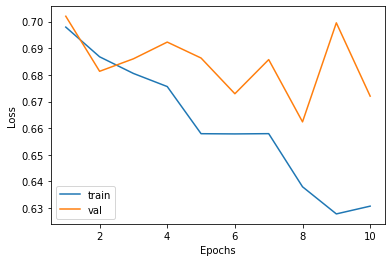

In [19]:
from tqdm import tqdm
total_train_losses = []
total_val_losses = []

ff=open('{}/progress.txt'.format(save_folder),'w')

for epoch in range(1,epochs+1):
    ##TRAINING##
    model.train()
    train_losses = []
    confusion_matrix.reset()

    for i, batch, in enumerate(tqdm(train_dataloader)):
        img_batch, lbl_batch = batch

        optimizer.zero_grad()
        output = model(img_batch.float())
        loss=criterion(output, lbl_batch.long())
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), lbl_batch.long())

        if i % 20 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_dataloader),100.*i/len(train_dataloader), loss.item()))

    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    confusion_matrix.reset()

     ##VALIDATION##
    model.eval()
    val_losses = []

    for i, batch, in enumerate(tqdm(val_dataloader)):
        img_batch, lbl_batch = batch
        outputs=model(img_batch.float())
        loss=criterion(outputs, lbl_batch.long())

        confusion_matrix.add(outputs.data.squeeze(), lbl_batch.long())
        val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)

    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()
    write_results(ff, save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

save_graph(total_train_losses, total_val_losses, epochs, save_folder)

In [21]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

test_images=list(glob.glob(os.path.join("./DL_LAB_4/DogsCats_Test.zip (Unzipped Files)/DogsCats_Test/*.jpg")))

net_args = {
    "block": BasicBlock,
    "layers": [2, 2, 2, 2]
}
model = ResNet(**net_args)
model.load_state_dict(torch.load('./DL_LAB_4/models/model_10.pt'))
model.eval()

confusion_matrix = tnt.meter.ConfusionMeter(2) 
confusion_matrix.reset()

for i in range(0, len(test_images)):
    img = io.imread(test_images[i])
    if 'dog' in test_images[i]:
      label = torch.tensor([0])
    else:
      label = torch.tensor([1])
    img = img/255.0 #normalization
    img = np.transpose(img, (2,0,1))
    img = np.reshape(img, (1, img.shape[0], img.shape[1], img.shape[2])) #reshape to (batchsize x channels x height x width)
    img = torch.from_numpy(img)
    output = F.log_softmax(model(img.float()), dim=1)
    confusion_matrix.add(output.data, label.long())

print(confusion_matrix.conf)

[[54 46]
 [38 62]]
